In [63]:
import openai
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import googlemaps
import math
from flask import Flask, request, jsonify, render_template
from IPython.display import IFrame, display, HTML
from dotenv import load_dotenv
import os
import requests
import time
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

# Load environment variables from the .env file
load_dotenv(dotenv_path='/Users/irisyu/Desktop/Project/virtual-housing-agent/.env')

# Access the variables
DATA_API_KEY = os.getenv('DATA_API_KEY')
MAPS_API_KEY = os.getenv('PLACES_API_KEY')
GEOCODING_KEY = os.getenv('GEOCODING_API_KEY')
OPENAI_KEY = os.getenv('OPENAI_API_KEY')

# Database

In [6]:
Data_URL = 'https://api.rentcast.io/v1/listings/rental/long-term'

In [7]:
params = {
    'city': 'San Francisco',
    'state': 'CA',
    'limit': 500,
    'status': 'Active', 
    'offset': 0
}

headers = {
    'Accept': 'application/json',
    'X-Api-Key': DATA_API_KEY
}

max_requests = 500  
all_listings = []
request_count = 0

In [8]:
try:
    for _ in range(max_requests):
        response = requests.get(Data_URL, headers=headers, params=params)
        request_count += 1
        
        if response.status_code == 200:
            listings = response.json() 
            if not isinstance(listings, list):
                print("Unexpected data format received.")
                break
            
            all_listings.extend(listings)
            
            print(f"Retrieved {len(listings)} rental listings. Total: {len(all_listings)}")
            
            if len(listings) < params['limit']:
                break
            
            params['offset'] += len(listings)
        else:
            print(f"Error: {response.status_code}")
            print(response.text)
            break
        
        time.sleep(1)

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

print(f"\nData retrieval completed.")
print(f"Total retrieved rental listings: {len(all_listings)}")
print(f"Total API requests made: {request_count}")


df = pd.DataFrame(all_listings)

Retrieved 500 rental listings. Total: 500
Retrieved 500 rental listings. Total: 1000
Retrieved 385 rental listings. Total: 1385

Data retrieval completed.
Total retrieved rental listings: 1385
Total API requests made: 3


In [9]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1385 non-null   object 
 1   formattedAddress  1385 non-null   object 
 2   addressLine1      1385 non-null   object 
 3   addressLine2      670 non-null    object 
 4   city              1385 non-null   object 
 5   state             1385 non-null   object 
 6   zipCode           1385 non-null   object 
 7   county            1385 non-null   object 
 8   latitude          1385 non-null   float64
 9   longitude         1385 non-null   float64
 10  propertyType      1385 non-null   object 
 11  bedrooms          1179 non-null   float64
 12  bathrooms         1338 non-null   float64
 13  squareFootage     803 non-null    float64
 14  status            1385 non-null   object 
 15  price             1385 non-null   int64  
 16  listedDate        1385 non-

In [10]:
df.head()

,id,formattedAddress,addressLine1,addressLine2,city,state,zipCode,county,latitude,longitude,...,squareFootage,status,price,listedDate,removedDate,createdDate,lastSeenDate,daysOnMarket,yearBuilt,lotSize
0,"2128-18th-St,-San-Francisco,-CA-94107","2128 18th St, San Francisco, CA 94107",2128 18th St,None,San Francisco,CA,94107,San Francisco,37.762327,-122.403924,...,1252.0,Active,4450,2023-07-06T00:00:00.000Z,None,2020-08-26T17:55:09.166Z,2024-07-04T03:49:38.385Z,366,NaN,NaN
1,"247-Saint-Charles-Ave,-San-Francisco,-CA-94132","247 Saint Charles Ave, San Francisco, CA 94132",247 Saint Charles Ave,None,San Francisco,CA,94132,San Francisco,37.709448,-122.469019,...,1300.0,Active,6500,2024-05-29T00:00:00.000Z,None,2024-05-29T00:00:00.000Z,2024-07-04T03:49:38.385Z,38,NaN,NaN
2,"1530-35th-Ave,-San-Francisco,-CA-94122","1530 35th Ave, San Francisco, CA 94122",1530 35th Ave,None,San Francisco,CA,94122,San Francisco,37.758496,-122.493638,...,0.0,Active,5500,2023-07-06T00:00:00.000Z,None,2018-11-02T01:41:29.908Z,2024-07-04T03:49:38.384Z,366,1932.0,NaN
3,"87-Maddux-Ave,-San-Francisco,-CA-94124","87 Maddux Ave, San Francisco, CA 94124",87 Maddux Ave,None,San Francisco,CA,94124,San Francisco,37.733797,-122.398225,...,2100.0,Active,4800,2023-07-06T00:00:00.000Z,None,2021-12-08T00:39:14.936Z,2024-07-04T03:49:38.384Z,366,2012.0,NaN
4,"1042-Minna-St,-Unit-1,-San-Francisco,-CA-94103","1042 Minna St, Unit 1, San Francisco, CA 94103",1042 Minna St,Unit 1,San Francisco,CA,94103,San Francisco,37.773472,-122.417349,...,1383.0,Active,5250,2023-07-06T00:00:00.000Z,None,2019-11-04T11:08:32.641Z,2024-07-04T03:49:38.383Z,366,NaN,NaN


# Data Processing

In [11]:
columns_to_drop = ['id', 'addressLine1','addressLine2', 'state', 'lotSize','listedDate','removedDate']
df = df.drop(columns=columns_to_drop)

df = df.drop_duplicates()

df.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,status,price,createdDate,lastSeenDate,daysOnMarket,yearBuilt
0,"2128 18th St, San Francisco, CA 94107",San Francisco,94107,San Francisco,37.762327,-122.403924,Single Family,3.0,1.0,1252.0,Active,4450,2020-08-26T17:55:09.166Z,2024-07-04T03:49:38.385Z,366,NaN
1,"247 Saint Charles Ave, San Francisco, CA 94132",San Francisco,94132,San Francisco,37.709448,-122.469019,Single Family,3.0,2.0,1300.0,Active,6500,2024-05-29T00:00:00.000Z,2024-07-04T03:49:38.385Z,38,NaN
2,"1530 35th Ave, San Francisco, CA 94122",San Francisco,94122,San Francisco,37.758496,-122.493638,Single Family,3.0,3.0,0.0,Active,5500,2018-11-02T01:41:29.908Z,2024-07-04T03:49:38.384Z,366,1932.0
3,"87 Maddux Ave, San Francisco, CA 94124",San Francisco,94124,San Francisco,37.733797,-122.398225,Single Family,3.0,2.0,2100.0,Active,4800,2021-12-08T00:39:14.936Z,2024-07-04T03:49:38.384Z,366,2012.0
4,"1042 Minna St, Unit 1, San Francisco, CA 94103",San Francisco,94103,San Francisco,37.773472,-122.417349,Condo,3.0,3.0,1383.0,Active,5250,2019-11-04T11:08:32.641Z,2024-07-04T03:49:38.383Z,366,NaN


In [13]:
from scipy import stats

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    df[col] = df[col].fillna(0)


categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'addressLine2':
        df[col] = df[col].fillna("Unknown")


if 'removedDate' in df.columns:
    df['removedDate'] = df['removedDate'].fillna("Not Removed")


def remove_outliers(df, column):
    z_scores = np.abs(stats.zscore(df[column]))
    return df[z_scores < 3]

for col in numeric_columns:
    df = remove_outliers(df, col)

df.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,status,price,createdDate,lastSeenDate,daysOnMarket,yearBuilt
0,"2128 18th St, San Francisco, CA 94107",San Francisco,94107,San Francisco,37.762327,-122.403924,Single Family,3.0,1.0,1252.0,Active,4450,2020-08-26T17:55:09.166Z,2024-07-04T03:49:38.385Z,366,0.0
3,"87 Maddux Ave, San Francisco, CA 94124",San Francisco,94124,San Francisco,37.733797,-122.398225,Single Family,3.0,2.0,2100.0,Active,4800,2021-12-08T00:39:14.936Z,2024-07-04T03:49:38.384Z,366,2012.0
5,"788 Minna St, Unit 202, San Francisco, CA 94103",San Francisco,94103,San Francisco,37.776067,-122.414074,Condo,1.0,1.0,680.0,Active,2599,2024-05-12T00:00:00.000Z,2024-07-04T03:49:38.383Z,55,0.0
6,"2023 Folsom St, San Francisco, CA 94110",San Francisco,94110,San Francisco,37.764902,-122.414949,Single Family,1.0,1.0,0.0,Active,2495,2022-05-31T01:46:15.934Z,2024-07-04T03:49:38.382Z,363,0.0
7,"15 Dorchester Way, San Francisco, CA 94127",San Francisco,94127,San Francisco,37.740310,-122.463639,Single Family,2.0,2.0,600.0,Active,2250,2024-06-29T00:00:00.000Z,2024-07-04T03:49:38.382Z,7,0.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1257 entries, 0 to 1384
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  1257 non-null   object 
 1   city              1257 non-null   object 
 2   zipCode           1257 non-null   object 
 3   county            1257 non-null   object 
 4   latitude          1257 non-null   float64
 5   longitude         1257 non-null   float64
 6   propertyType      1257 non-null   object 
 7   bedrooms          1257 non-null   float64
 8   bathrooms         1257 non-null   float64
 9   squareFootage     1257 non-null   float64
 10  status            1257 non-null   object 
 11  price             1257 non-null   int64  
 12  createdDate       1257 non-null   object 
 13  lastSeenDate      1257 non-null   object 
 14  daysOnMarket      1257 non-null   int64  
 15  yearBuilt         1257 non-null   float64
dtypes: float64(6), int64(2), object(8)
memory usage

# Exploratory Data Analysis

In [15]:
df.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,price,daysOnMarket,yearBuilt
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,37.779556,-122.421423,1.210819,1.142800,456.423230,3339.818616,119.233890,528.384248
std,0.016960,0.020118,0.952341,0.446249,520.357002,1385.818504,134.214871,873.675052
min,37.719715,-122.493223,0.000000,0.000000,0.000000,995.000000,1.000000,0.000000
25%,37.772771,-122.429436,1.000000,1.000000,0.000000,2329.000000,22.000000,0.000000
50%,37.783533,-122.418243,1.000000,1.000000,394.000000,3095.000000,65.000000,0.000000
75%,37.790644,-122.410797,2.000000,1.000000,753.000000,4000.000000,151.000000,1906.000000
max,37.811424,-122.365562,4.000000,2.500000,3638.000000,8500.000000,366.000000,2022.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


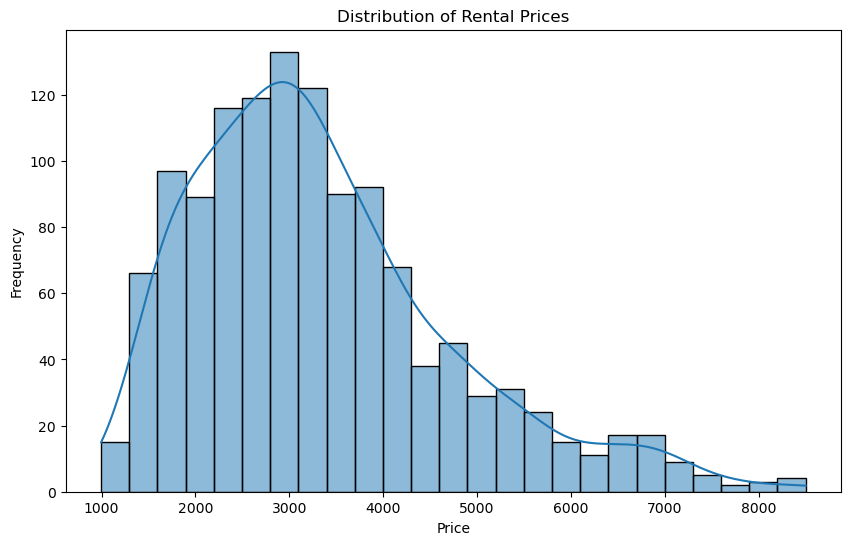

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


#Rent Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

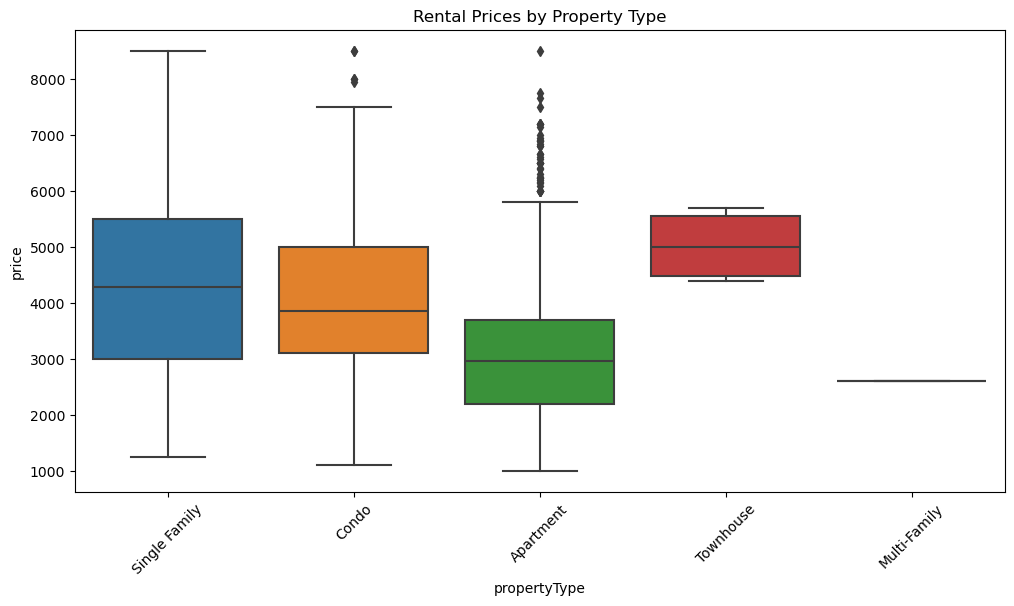

In [17]:
# Rent Price across Property Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='propertyType', y='price', data=df)
plt.title('Rental Prices by Property Type')
plt.xticks(rotation=45)
plt.show()

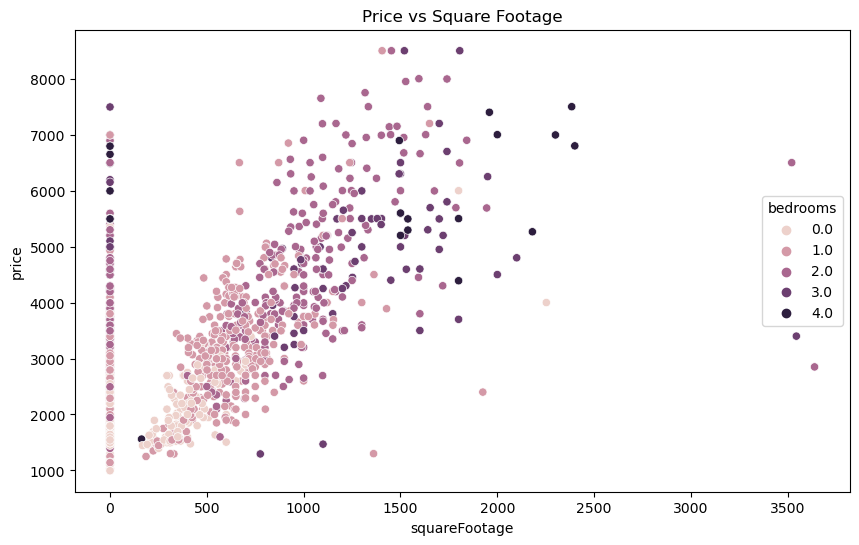

In [18]:
# Price vs Square Footage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='squareFootage', y='price', hue='bedrooms', data=df)
plt.title('Price vs Square Footage')
plt.show()

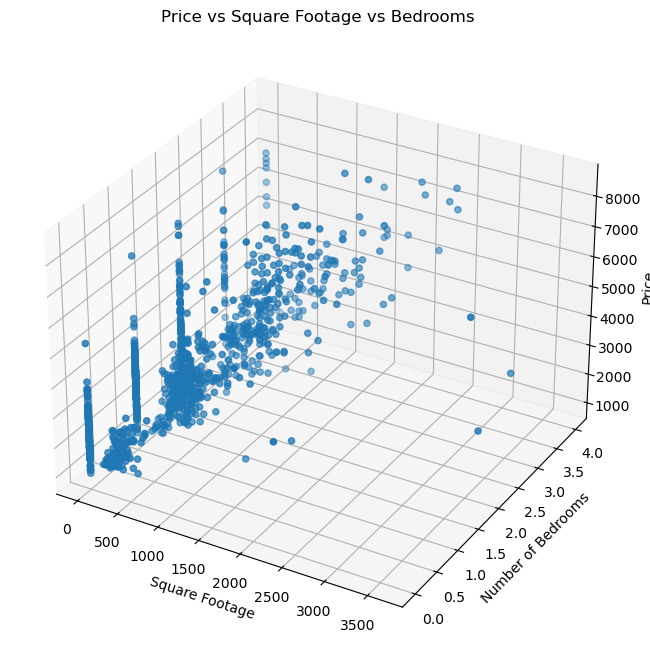

In [19]:
#Price vs Square Footage vs Bedrooms
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['squareFootage'], df['bedrooms'], df['price'])
ax.set_xlabel('Square Footage')
ax.set_ylabel('Number of Bedrooms')
ax.set_zlabel('Price')
plt.title('Price vs Square Footage vs Bedrooms')
plt.show()

In [71]:
import folium
from folium.plugins import MarkerCluster
import webbrowser
import os


sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

marker_cluster = MarkerCluster().add_to(sf_map)

def get_color(price):
    if price < 2000:
        return 'green'
    elif price < 3000:
        return 'yellow'
    elif price < 4000:
        return 'orange'
    else:
        return 'red'


for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"Price: ${row['price']}, Bedrooms: {row['bedrooms']}",
        color=get_color(row['price']),
        fill=True,
        fillColor=get_color(row['price'])
    ).add_to(marker_cluster)

legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 120px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; Price Legend <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i> &lt; $2000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:yellow"></i> $2000-$3000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:orange"></i> $3000-$4000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i> &gt; $4000
</div>
'''
sf_map.get_root().html.add_child(folium.Element(legend_html))


map_file = "sf_rentals_map.html"
sf_map.save(map_file)


file_path = os.path.abspath(map_file)


webbrowser.open('file://' + file_path)

True

In [21]:
gmaps_places = googlemaps.Client(key=MAPS_API_KEY)
gmaps_geocoding = googlemaps.Client(key=GEOCODING_KEY)

def autocomplete_place(input_text):
    predictions = gmaps_places.places_autocomplete(input_text, types='geocode')
    return predictions

def get_lat_lng_from_place_id(place_id):
    result = gmaps_geocoding.place(place_id=place_id)
    location = result['result']['geometry']['location']
    return location['lat'], location['lng']


# Recommendation System

In [64]:
#functions for geocoding/sentimential analyzer

# Haversine function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return R * c

# Function to get sentiment score
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def sentiment_score(text):
    return sia.polarity_scores(text)["compound"]

# Function to fetch Google Maps reviews
def fetch_reviews(place_id, max_reviews=100):
    reviews = []
    place_details = gmaps_places.place(place_id=place_id)
    if 'reviews' in place_details['result']:
        reviews.extend(place_details['result']['reviews'][:max_reviews])
    return reviews

# Example function to search for a place and get its place_id
def search_place(query):
    places_result = gmaps_places.places(query)
    if places_result['results']:
        return places_result['results'][0]['place_id']
    return None

# Function to analyze reviews and get sentiment scores for relevant features
def analyze_reviews(reviews):
    review_data = {
        "review_text": [review['text'] for review in reviews],
        "sentiment_score": [sentiment_score(review['text']) for review in reviews]
    }
    reviews_df = pd.DataFrame(review_data)
    avg_sentiment_score = reviews_df['sentiment_score'].mean()
    return avg_sentiment_score

# Cache to store place IDs and their sentiment scores
place_cache = {}

def get_reviews_for_listings(filtered_df, max_reviews_per_listing=100):
    filtered_df['place_id'] = filtered_df['formattedAddress'].apply(lambda x: place_cache.get(x, search_place(x)))
    filtered_df['sentiment_score'] = 0.0

    for index, row in filtered_df.iterrows():
        if row['place_id']:
            if row['place_id'] not in place_cache:
                reviews = fetch_reviews(row['place_id'], max_reviews=max_reviews_per_listing)
                if reviews:
                    avg_sentiment_score = analyze_reviews(reviews)
                    place_cache[row['place_id']] = avg_sentiment_score
                else:
                    place_cache[row['place_id']] = 0.0
            filtered_df.at[index, 'sentiment_score'] = place_cache[row['place_id']]
    return filtered_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/irisyu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [86]:
# Hard Metric Recommendation

def calculate_score(row, criteria, weights):
    score = 0
    score += weights['bedrooms'] * (1 if row['bedrooms'] >= criteria['bedrooms'] else 0)
    score += weights['bathrooms'] * (1 if row['bathrooms'] >= criteria['bathrooms'] else 0)
    score += weights['price'] * (1 - row['price'])
    score += weights['distance'] * (1 - row['distance'])
    return score

def autocomplete_place(input_text):
    predictions = gmaps_places.places_autocomplete(input_text, types='geocode')
    return predictions

def get_lat_lng_from_place_id(place_id):
    result = gmaps_places.place(place_id=place_id)
    location = result['result']['geometry']['location']
    return location['lat'], location['lng']

def filter_listings(df, criteria, weights):
    df['original_price'] = df['price'].copy()
    filtered_df = df[
        (df['bedrooms'] >= criteria['bedrooms']) &
        (df['bathrooms'] >= criteria['bathrooms']) &
        (df['price'] >= criteria['min_rent']) &
        (df['price'] <= criteria['max_rent'])
    ].copy()
    
    if filtered_df.empty:
        print("No listings found that match your criteria.")
        return filtered_df

    try:
        predictions = autocomplete_place(criteria['location'])
        if predictions:
            place_id = predictions[0]['place_id']
            lat, lng = get_lat_lng_from_place_id(place_id)
            
            filtered_df['distance'] = filtered_df.apply(lambda row: haversine(lat, lng, row['latitude'], row['longitude']), axis=1)
            filtered_df = filtered_df[filtered_df['distance'] <= criteria['max_distance_km']]
        
        if not filtered_df.empty:
            scaler = MinMaxScaler()
            filtered_df[['price', 'distance']] = scaler.fit_transform(filtered_df[['price', 'distance']])
        
            filtered_df['score'] = filtered_df.apply(lambda row: calculate_score(row, criteria, weights), axis=1)
            filtered_df = filtered_df.sort_values('score', ascending=False)
        else:
            print("No listings found after applying distance filter.")
            return filtered_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()
    
    return filtered_df


In [88]:
def display_results(filtered_df):
    if filtered_df.empty:
        print("No listings found that match your criteria.")
    else:
        print(f"Found {len(filtered_df)} listings that match your criteria:")
        print(filtered_df[['formattedAddress', 'price', 'bedrooms', 'bathrooms', 'squareFootage', 'distance', 'score']])

In [89]:
def get_user_input():
    print("Let's find your ideal rental property!")
    
    criteria = {}
    weights = {}
    
    try:
        criteria['bedrooms'] = float(input("Enter number of bedrooms (e.g., 1, 2, 3): "))
        criteria['bathrooms'] = float(input("Enter number of bathrooms (e.g., 1, 1.5, 2): "))
        
        criteria['min_rent'] = float(input("Minimum rent price: "))
        criteria['max_rent'] = float(input("Maximum rent price: "))
        
        criteria['location'] = input("Enter desired location (you can input zip code, neighborhood, building name, or landmark): ")
        
        criteria['move_in_date'] = input("Enter moving-in date (YYYY-MM-DD): ")
        criteria['lease_term'] = int(input("Enter lease term (in months): "))
        
        criteria['max_distance_km'] = float(input("Enter maximum distance from the location (in kilometers): "))
        
        print("\nNow, let's set the importance of each criterion.")
        print("Please rate the importance of each criterion from 1 (least important) to 10 (most important):")
        
        weights['bedrooms'] = float(input("Importance of number of bedrooms: ")) / 10
        weights['bathrooms'] = float(input("Importance of number of bathrooms: ")) / 10
        weights['price'] = float(input("Importance of price: ")) / 10
        weights['distance'] = float(input("Importance of distance from desired location: ")) / 10
    except ValueError as e:
        print(f"Invalid input: {e}. Please enter numeric values where required.")
        return None, None
    
    return criteria, weights


In [90]:
def enhanced_filter_listings(filtered_df, soft_weights):
    if filtered_df.empty:
        print("No listings available for further filtering.")
        return filtered_df

    # Get reviews and analyze sentiment
    filtered_df = get_reviews_for_listings(filtered_df)

    # Calculate enhanced score
    filtered_df['enhanced_score'] = (
        filtered_df['score'] +
        filtered_df['sentiment_score'] * soft_weights['sentiment']
    )

    return filtered_df.sort_values('enhanced_score', ascending=False)


In [94]:
def visualize_results_on_map(df):
    sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
    marker_cluster = MarkerCluster().add_to(sf_map)

    for rank, (index, row) in enumerate(df.iterrows(), start=1):
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=(
                f"Rank: {rank}<br>"
                f"Address: {row['formattedAddress']}<br>"
                f"Price: ${row['original_price']}<br>"
                f"Bedrooms: {row['bedrooms']}<br>"
                f"Bathrooms: {row['bathrooms']}<br>"
                f"Score: {row['enhanced_score']:.2f}"
            ),
            icon=folium.Icon(color='blue')
        ).add_to(marker_cluster)

    # Save the map as HTML file
    map_file = "recommended_listings_map.html"
    sf_map.save(map_file)
    print(f"Map saved to {map_file}")

    return map_file

def open_map(map_file):
    webbrowser.open('file://' + os.path.realpath(map_file))

# Main execution
if __name__ == "__main__":
    soft_weights = {
        "sentiment": 0.5
    }

    criteria, weights = get_user_input()
    if criteria and weights:
        filtered_listings = filter_listings(df, criteria, weights)
        if not filtered_listings.empty:
            enhanced_filtered_listings = enhanced_filter_listings(filtered_listings.head(20), soft_weights)
            display_results(enhanced_filtered_listings)
            map_file = visualize_results_on_map(enhanced_filtered_listings)
            open_map(map_file)
        else:
            print("No listings found that match your criteria.")
    else:
        print("Failed to get valid user input. Please try again.")


Let's find your ideal rental property!

Now, let's set the importance of each criterion.
Please rate the importance of each criterion from 1 (least important) to 10 (most important):


/var/folders/cg/skgvx5ds71j6114m1yy9bc5r0000gn/T/ipykernel_12445/446050615.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['place_id'] = filtered_df['formattedAddress'].apply(lambda x: place_cache.get(x, search_place(x)))
/var/folders/cg/skgvx5ds71j6114m1yy9bc5r0000gn/T/ipykernel_12445/446050615.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment_score'] = 0.0


Found 20 listings that match your criteria:
                                       formattedAddress  price  bedrooms  \
908      2 Mint Plz, Unit 308L, San Francisco, CA 94103  0.000       1.0   
646             399 Fremont St, San Francisco, CA 94105  0.120       1.0   
924     916 Pacific Ave, Apt 9, San Francisco, CA 94133  0.125       1.0   
448        1181 Clay St, Apt 5, San Francisco, CA 94108  0.250       2.0   
67       400 Spear St, Apt 208, San Francisco, CA 94105  0.500       1.0   
531       2215 Gough St, Apt 3, San Francisco, CA 94109  0.250       1.0   
1176  1095 Rhode Island St, Unit A, San Francisco, C...  0.250       1.0   
111      1095A Rhode Island St, San Francisco, CA 94107  0.250       1.0   
1179      665 Pine St, Apt 403, San Francisco, CA 94108  0.475       1.0   
672        737 Pine St, Apt 24, San Francisco, CA 94108  0.475       1.0   
88    647 Stockton St, Unit 302, San Francisco, CA 9...  0.475       1.0   
196       52 Joice St, Unit 10, San Francisc

/var/folders/cg/skgvx5ds71j6114m1yy9bc5r0000gn/T/ipykernel_12445/3207794441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['enhanced_score'] = (
